In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
!nvidia-smi

Thu Feb 16 13:28:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8     9W / 250W |    447MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="6"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
config = dict(
    saved_path="saved/random.pt",
    best_saved_path = "saved/random_best.pt",
    lr=0.001, 
    EPOCHS = 3,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 32,
    TRAIN_VALID_SPLIT = 0.2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=3,
    USE_AMP = True,
    channels_last=False)

In [6]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((config['IMAGE_SIZE'],config['IMAGE_SIZE'])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# SHVN dataset

In [8]:
train_data = torchvision.datasets.SVHN(root='../Images', split = 'train',
                                        download=True, transform=data_transforms['train'])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])

test_data = torchvision.datasets.SVHN(root='../Images', split='test',
                                       download=True, transform=data_transforms['test'])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = test_dl

Using downloaded and verified file: ../Images/train_32x32.mat
Using downloaded and verified file: ../Images/test_32x32.mat


In [9]:
valid_data = test_data
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

tensor([4, 7, 0, 9, 1, 2, 9, 3, 1, 9, 9, 1, 1, 7, 8, 7, 3, 8, 6, 4, 2, 2, 5, 3,
        5, 2, 8, 0, 4, 2, 1, 5])


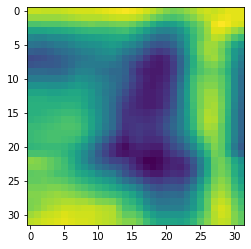

In [10]:
import matplotlib.pyplot as plt
a = iter(valid_dl)
b = next(a)
print(b[1])
plt.imshow(b[0][0][0])

In [11]:
def train_model(model,criterion,optimizer,num_epochs=10):

    since = time.time()                                            
    batch_ct = 0
    example_ct = 0
    best_acc = 0.3
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        run_corrects = 0
        #Training
        model.train()
        for x,y in train_dl: #BS=32 ([BS,3,224,224], [BS,4])            
            if config['channels_last']:
                x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
            else:
                x = x.to(config['device'])
            y = y.to(config['device']) #CHW --> #HWC
            
            
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) #Input = [BS,3,224,224] (Image) -- Model --> [BS,4] (Output Scores)
            
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss=train_loss

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            if ((batch_ct + 1) % 400) == 0:
                train_log(loss, example_ct, epoch)
            ########################################################################
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                if config['channels_last']:
                    x = x.to(config['device'], memory_format=torch.channels_last) #CHW --> #HWC
                else:
                    x = x.to(config['device'])
                y = y.to(config['device'])
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}\n".format(epoch_acc.cpu()))
        if epoch_acc.cpu()>best_acc:
            print('One of the best validation accuracy found.\n')
            #torch.save(model.state_dict(), config['best_saved_path'])
            best_acc = epoch_acc.cpu()

            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    #torch.save(model.state_dict(), config['saved_path'])

    
def train_log(loss, example_ct, epoch):
    loss = float(loss)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

# Architecture-1: Squeezenet

In [12]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
model = squeezenet

In [13]:
model = model.to(config['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
train_model(model,criterion,optimizer,num_epochs=10)

Epoch 0/9
----------
Loss after 12768 examples: 1.876
Loss after 25568 examples: 1.662
Loss after 38368 examples: 2.146
Loss after 51168 examples: 1.964
Loss after 63968 examples: 1.876
Train Accuracy tensor(0.3441, dtype=torch.float64)
Validation Loss is 1.340528725112371
Validation Accuracy is 0.5864320835894283

One of the best validation accuracy found.

Epoch 1/9
----------
Loss after 76745 examples: 1.507
Loss after 89545 examples: 1.902
Loss after 102345 examples: 1.244
Loss after 115145 examples: 1.330
Loss after 127945 examples: 1.329
Loss after 140745 examples: 0.949
Train Accuracy tensor(0.5045, dtype=torch.float64)
Validation Loss is 1.0833171721463124
Validation Accuracy is 0.6660264290104486

One of the best validation accuracy found.

Epoch 2/9
----------
Loss after 153522 examples: 1.695
Loss after 166322 examples: 1.447
Loss after 179122 examples: 1.751
Loss after 191922 examples: 1.040
Loss after 204722 examples: 1.898
Loss after 217522 examples: 1.479
Train Accuracy 

# Mask Based attack

In [14]:
def mask_based_attack(model, images, labels, epsilon=0.03):
    model.eval()
    images = images.clone().detach().requires_grad_(True)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    grad = images.grad.data
    sign = grad.sign()
    perturbed_images = images + epsilon * sign
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    return perturbed_images


In [15]:
def evaluate_mask_attack(epsilon = 0.03):
    correct = 0
    total = 0

    #with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad flag to True
        images.requires_grad = True

        # Compute the gradient
        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        grad = torch.autograd.grad(loss, images, retain_graph=True, only_inputs=True)[0]
        data_grad = grad.data

        # Generate adversarial examples
        perturbed_images = mask_based_attack(model, images, labels, epsilon)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Reset requires_grad flag back to False
        images.requires_grad = False
    print('For Epsilon = ', epsilon)
    print('Accuracy on perturbed mask attack data: %d %%' % (100 * correct / total))
evaluate_mask_attack()


For Epsilon =  0.03
Accuracy on perturbed mask attack data: 48 %


In [16]:
for e in [0,0.01,0.05,0.1]:
    evaluate_mask_attack(e)
    print()

For Epsilon =  0
Accuracy on perturbed mask attack data: 54 %

For Epsilon =  0.01
Accuracy on perturbed mask attack data: 52 %

For Epsilon =  0.05
Accuracy on perturbed mask attack data: 43 %

For Epsilon =  0.1
Accuracy on perturbed mask attack data: 35 %



# PGD Attack

In [17]:
def pgd_attack(images, targets, net, criterion, epsilon=0.1, alpha=0.01, num_iter=40):
#     images = images.clone().detach().to(device)
#     targets = targets.clone().detach().to(device)

    # Create a perturbation vector of the same shape as the input images
    perturbation = torch.zeros_like(images).to(device)

    for i in range(num_iter):
        # Zero out the gradients
        net.zero_grad()

        # Compute the loss and the gradients of the loss with respect to the inputs
        loss = criterion(net(images + perturbation), targets)
        loss.backward()

        # Add the gradient of the loss to the perturbation vector
        perturbation = (perturbation + alpha * torch.sign(images.grad.data)).clamp(-epsilon, epsilon)
        
        # Clamp the perturbed images to the valid range
        perturbed_images = (images + perturbation).clamp(0, 1)

        # Zero out the gradients
        net.zero_grad()

        # Compute the loss and the gradients of the loss with respect to the inputs
        loss = criterion(net(perturbed_images), targets)
        loss.backward()

    # Return the perturbed images
    return perturbed_images


In [18]:
def evaluate_pgd(epsilon = 0.03):
    correct = 0
    total = 0

    #with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad flag to True
        images.requires_grad = True

        # Compute the gradient
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Generate adversarial examples
        perturbed_images = pgd_attack(images, labels, model, criterion, epsilon)
        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Reset requires_grad flag back to False
        images.requires_grad = False

    print('For Epsilon = ', epsilon)
    print('Accuracy on PGD attacked data: %d %%' % (100 * correct / total))
evaluate_pgd()


For Epsilon =  0.03
Accuracy on PGD attacked data: 35 %


In [19]:
for e in [0,0.01,0.05,0.1]:
    evaluate_pgd(e)
    print()

For Epsilon =  0
Accuracy on PGD attacked data: 54 %

For Epsilon =  0.01
Accuracy on PGD attacked data: 47 %

For Epsilon =  0.05
Accuracy on PGD attacked data: 26 %

For Epsilon =  0.1
Accuracy on PGD attacked data: 15 %



# Architecture-2: Shufflenet

In [20]:
shufflenet = models.shufflenet_v2_x1_0(pretrained = True)
shufflenet.fc = nn.Linear(in_features = 1024, out_features = 10, bias=True)
model = shufflenet

In [21]:
model = model.to(config['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
train_model(model,criterion,optimizer,num_epochs=10)

Epoch 0/9
----------
Loss after 12768 examples: 1.432
Loss after 25568 examples: 1.355
Loss after 38368 examples: 1.067
Loss after 51168 examples: 1.303
Loss after 63968 examples: 0.873
Train Accuracy tensor(0.5682, dtype=torch.float64)
Validation Loss is 0.7145773142338092
Validation Accuracy is 0.7768131530424093

One of the best validation accuracy found.

Epoch 1/9
----------
Loss after 76745 examples: 0.871
Loss after 89545 examples: 1.409
Loss after 102345 examples: 0.890
Loss after 115145 examples: 0.718
Loss after 127945 examples: 1.178
Loss after 140745 examples: 0.798
Train Accuracy tensor(0.6633, dtype=torch.float64)
Validation Loss is 0.579504482461839
Validation Accuracy is 0.8250230485556238

One of the best validation accuracy found.

Epoch 2/9
----------
Loss after 153522 examples: 1.327
Loss after 166322 examples: 0.934
Loss after 179122 examples: 1.094
Loss after 191922 examples: 0.977
Loss after 204722 examples: 0.651
Loss after 217522 examples: 1.397
Train Accuracy 

In [22]:
# Mask Attack
for e in [0,0.01,0.03,0.05,0.1]:
    evaluate_mask_attack(e)
    print()

For Epsilon =  0
Accuracy on perturbed mask attack data: 63 %

For Epsilon =  0.01
Accuracy on perturbed mask attack data: 55 %

For Epsilon =  0.03
Accuracy on perturbed mask attack data: 44 %

For Epsilon =  0.05
Accuracy on perturbed mask attack data: 37 %

For Epsilon =  0.1
Accuracy on perturbed mask attack data: 28 %



In [ ]:
# PGD Attack
for e in [0,0.01,0.03,0.05,0.1]:
    evaluate_pgd(e)
    print()

For Epsilon =  0
Accuracy on PGD attacked data: 63 %

For Epsilon =  0.01
Accuracy on PGD attacked data: 40 %

